# Практическая работа №2

## Тема: Анализ логов
Выполнил: Очередько Антон


Клонирование репозитория с логами:

In [ ]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 575 (delta 146), reused 136 (delta 134), pack-reused 401
Receiving objects: 100% (575/575), 7.27 MiB | 5.12 MiB/s, done.
Resolving deltas: 100% (267/267), done.


Описание структуры полей логов и разработка парсера

Возьмем строчку из логов Thunderbird:
```
1131566461 2005.11.09 dn754 Nov 9 12:01:01 dn754/dn754 crond(pam_unix)[2913]: session closed for user root
1131566461 2005.11.09 dn754 Nov 9 12:01:01 dn754/dn754 crond(pam_unix)[2913]: session opened for user root by (uid=0)
```
Регулярное выражение извлекает все поля записи лога и делит его на следующие группы:

- Timestamp - временная метка `(\d{10})`
- Date - Дата YYYY:MM:DD `(\d{4}.\d{2}.\d{2})`
- User - Пользователь `(\w*)`
- Month - Месяц `(\w{3})`
- Day - День `(\d{1,2})`
- Time - Время HH:MM:SS `(\d{2}:\d{2}:\d{2})`
- Location - Местоположение `([\w\/#@-]+)`
- Component - Компонент `(.*\:):`
- PID - Идентификатор `[(\d+)\]`
- Content - Сообщение `(.*)`

In [ ]:
import re

pattern = r'-\s(\d{10})\s(\d{4}\.\d{2}\.\d{2})\s(.*)\s([\w]{3})\s(\d{1,2})\s(\d{2}:\d{2}:\d{2})\s([\w\/#@-]+)\s(.*)\[(\d+)\]:\s(.*)'

Создание Базы Данных

In [ ]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

In [ ]:
import sqlite3

db_path = './db/logs.db'

connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DROP TABLE IF EXISTS logs")
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, timestamp, date, user, month, day, time, location, component, pid, content)")

connection.commit()
cursor.close()
connection.close()

Парсинг логов и сохранение записей

In [ ]:
#подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

#очистка таблицы (во избежания дублирования данных)
cursor.execute("DELETE FROM logs")

#парсинг файла с логами
with open('./loghub/Thunderbird/Thunderbird_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = re.match(pattern, line)
        if log_match:
            timestamp = log_match.group(1) # Временная метка
            date = log_match.group(2) # Дата
            user = log_match.group(3) # Пользователь
            month = log_match.group(4) # Месяц
            day = log_match.group(5) # День
            time = log_match.group(6) # Время
            location = log_match.group(7) # Местоположение
            component = log_match.group(8) # Компонент
            pid = log_match.group(9) # Идентификатор
            content = log_match.group(10) # Сообщение
            values = (timestamp, date, user, month, day, time, location, component, pid, content)
            sql = "INSERT INTO logs (timestamp, date, user, month, day, time, location, component, pid, content) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
            cursor.execute(sql, values)


connection.commit()
cursor.close()
connection.close()

Чтение записей из БД

In [ ]:
import pandas as pd

#установка соединения с базой данных
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

#выполнение запроса к базе данных и получиение данные
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

#закрытие курсора и соединения с базой данных
cursor.close()
connection.close()

#создание DataFrame из полученных данных
log_df = pd.DataFrame(rows, columns=("id", "timestamp", "date", "user", "month", "day", "time", "location", "component", "pid", "content"))

#вывод DataFrame
log_df

,id,timestamp,date,user,month,day,time,location,component,pid,content
0,1,1131566461,2005.11.09,dn228,Nov,9,12:01:01,dn228/dn228,crond(pam_unix),2915,session closed for user root
1,2,1131566461,2005.11.09,dn228,Nov,9,12:01:01,dn228/dn228,crond(pam_unix),2915,session opened for user root by (uid=0)
2,3,1131566461,2005.11.09,dn228,Nov,9,12:01:01,dn228/dn228,crond,2916,(root) CMD (run-parts /etc/cron.hourly)
3,4,1131566461,2005.11.09,dn261,Nov,9,12:01:01,dn261/dn261,crond(pam_unix),2907,session closed for user root
4,5,1131566461,2005.11.09,dn261,Nov,9,12:01:01,dn261/dn261,crond(pam_unix),2907,session opened for user root by (uid=0)
...,...,...,...,...,...,...,...,...,...,...,...
1740,1741,1131567330,2005.11.09,bn964,Nov,9,12:15:30,bn964/bn964,ntpd,15605,"synchronized to 10.100.22.250, stratum 3"
1741,1742,1131567330,2005.11.09,tbird-admin1,Nov,9,12:15:30,local@tbird-admin1,/apps/x86_64/system/ganglia-3.0.1/sbin/gmetad,1682,data_thread() got not answer from any [Thunder...
1742,1743,1131567331,2005.11.09,bn3,Nov,9,12:15:31,bn3/bn3,ntpd,22869,"synchronized to 10.100.16.250, stratum 3"
1743,1744,1131567331,2005.11.09,cn918,Nov,9,12:15:31,cn918/cn918,ntpd,29960,"synchronized to 10.100.22.250, stratum 3"


Построение графика действий пяти наиболее часто встречающихся пользователей

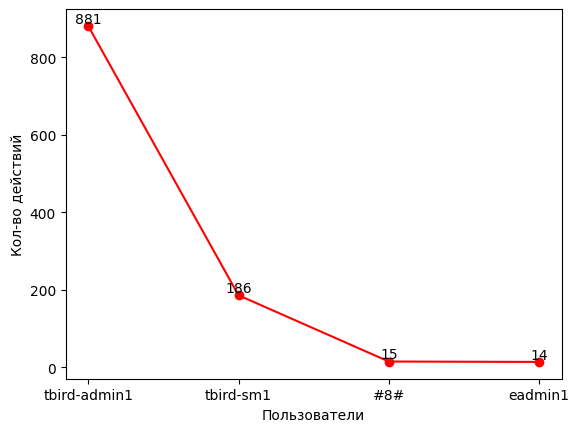

In [ ]:
import matplotlib.pyplot as plt

#выполнение подсчета распределения пользователей
log_user_distrib = log_df['user'].value_counts()

#получение ключей (пользователи) и их значения (количество действий)
x = log_user_distrib.keys()
y = log_user_distrib.values

#построение графика
plt.xlabel('Пользователи')
plt.ylabel('Кол-во действий')
plt.plot(x[:4], y[:4], marker='o', color='red')
for i, txt in enumerate(y[:4]):
    plt.text(x[i], y[i], str(txt), ha='center', va='bottom')

#отображение графика
plt.show()

Создание графика, который отображает распределение записей по 10 наиболее часто встречающимся компонентам, которые создали записи в логах

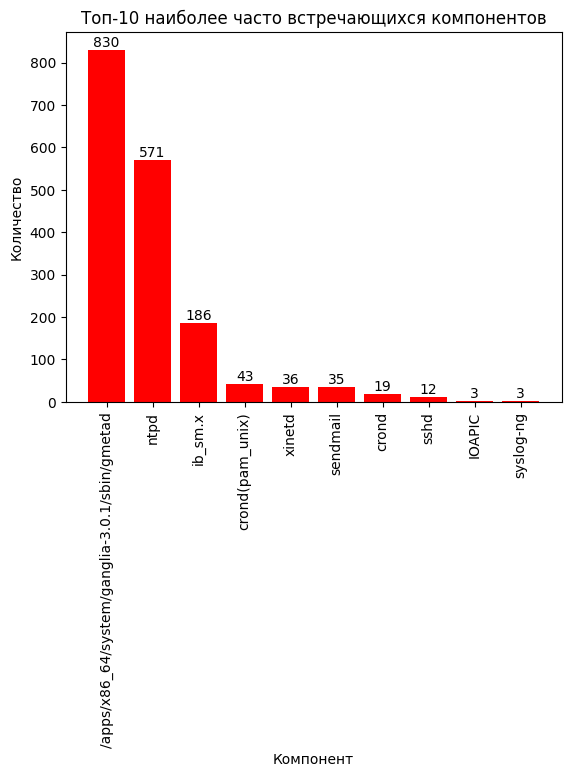

In [ ]:
#подсчет распределения компонентов
component_counts = log_df['component'].value_counts()

#топ-10 наиболее часто встречающихся компонентов
top_10_components = component_counts.head(10)

#название графика
plt.title('Топ-10 наиболее часто встречающихся компонентов')

#построение графика распределения
plt.bar(top_10_components.index, top_10_components.values, color='red')

#добавление подписи к осям
plt.xlabel('Компонент')
plt.ylabel('Количество')

#поворот подписи категорий столбцов на 90 градусов, для удобства чтения
plt.xticks(rotation=90)
for i, value in enumerate(top_10_components.values):
    plt.text(i, value, str(value), ha='center', va='bottom')

#отображение графика
plt.show()

Создание графика, который отображает распределение записей по 10 наименее часто встречающимся компонентам, которые создали записи в логах

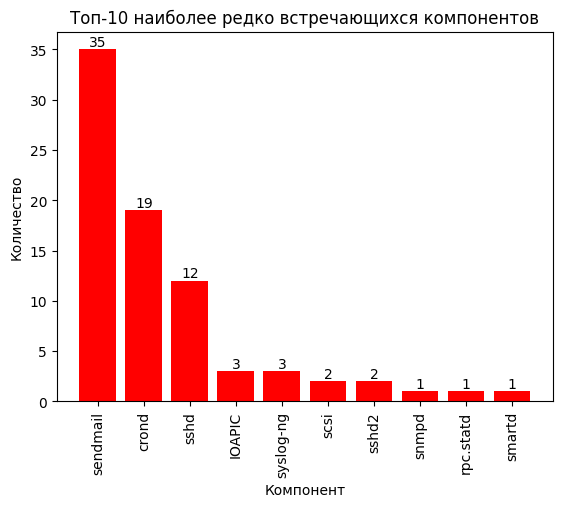

In [ ]:
#подсчет распределения компонентов
component_counts = log_df['component'].value_counts()

#топ-10 наиболее редко встречающихся компонентов
top_10_rarest_components = component_counts.tail(10)

#название графика
plt.title('Топ-10 наиболее редко встречающихся компонентов')

#построение графика распределения
plt.bar(top_10_rarest_components.index, top_10_rarest_components.values, color='red')

#добавление подписи к осям
plt.xlabel('Компонент')
plt.ylabel('Количество')

#поворот подписи категорий столбцов на 90 градусов, для удобства чтения
plt.xticks(rotation=90)
for i, value in enumerate(top_10_rarest_components.values):
    plt.text(i, value, str(value), ha='center', va='bottom')

#отображение графика
plt.show()
